<a href="https://colab.research.google.com/github/Shakshi3104/HAR-competition/blob/master/autokeras_hasc_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HASC-competition via AutoKeras

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install AutoKeras

In [ ]:
!pip install autokeras

     |████████████████████████████████| 174kB 18.7MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=67b3deb753b519bdc0655f12ba8af6bd57134676178952c782af772ff31b545a
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=9e862fc98cdb19938eea9926cd0309bd3bb7f86bb8098e2162b669713239f01e
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


## Copy dataset

In [ ]:
!cp /content/drive/Shareddrives/HaseLab共有ドライブ/999_その他/MLコンペ風データセット/HASC_Apple_100.zip .
!unzip HASC_Apple_100.zip
!mkdir HASC_Apple_100
!mv ФzХzЧp HASC_Apple_100/.
!mv HASC_Apple_100/ФzХzЧp HASC_Apple_100/配布用

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: ФzХzЧp/dataset_3/43250.csv  
  inflating: ФzХzЧp/dataset_3/43251.csv  
  inflating: ФzХzЧp/dataset_3/43252.csv  
  inflating: ФzХzЧp/dataset_3/43253.csv  
  inflating: ФzХzЧp/dataset_3/43254.csv  
  inflating: ФzХzЧp/dataset_3/43255.csv  
  inflating: ФzХzЧp/dataset_3/43256.csv  
  inflating: ФzХzЧp/dataset_3/43257.csv  
  inflating: ФzХzЧp/dataset_3/43258.csv  
  inflating: ФzХzЧp/dataset_3/43259.csv  
  inflating: ФzХzЧp/dataset_3/43260.csv  
  inflating: ФzХzЧp/dataset_3/43261.csv  
  inflating: ФzХzЧp/dataset_3/43262.csv  
  inflating: ФzХzЧp/dataset_3/43263.csv  
  inflating: ФzХzЧp/dataset_3/43264.csv  
  inflating: ФzХzЧp/dataset_3/43265.csv  
  inflating: ФzХzЧp/dataset_3/43266.csv  
  inflating: ФzХzЧp/dataset_3/43267.csv  
  inflating: ФzХzЧp/dataset_3/43268.csv  
  inflating: ФzХzЧp/dataset_3/43269.csv  
  inflating: ФzХzЧp/dataset_3/43270.csv  
  inflating: ФzХzЧp/dataset_3/43271.csv  
  inflating: ФzХzЧp/dataset_3/43272.csv  
  

## git clone

In [ ]:
!rm -rf HAR-competition/
!git clone https://github.com/Shakshi3104/HAR-competition.git

Cloning into 'HAR-competition'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 110 (delta 65), reused 77 (delta 32), pack-reused 0
Receiving objects: 100% (110/110), 20.97 KiB | 6.99 MiB/s, done.
Resolving deltas: 100% (65/65), done.


## Path append

In [ ]:
import sys
sys.path.append("/content/HAR-competition/")

## Main

### Import

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

2.4.1
/device:GPU:0


In [ ]:
import numpy as np
import random

In [ ]:
import autokeras as ak
import kerastuner as kt

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
import dataset
import utils

### Config parameter

In [ ]:
CLASSES = 6

batch = 512
epochs = 100

SEED = 0

In [ ]:
# Set random seed
np.random.seed(SEED)
random.seed(SEED)

### Load dataset

In [ ]:
x_train, y_train, x_test, y_test = dataset.load_hasc()
print(x_train.shape)
print(y_test.shape)

# Reshape
y_train = to_categorical(y_train, num_classes=CLASSES)
y_test_ = to_categorical(y_test, num_classes=CLASSES)

print(x_train.shape)
print(y_test_.shape)

(12891, 512, 3)
(4216,)
(12891, 512, 3)
(4216, 6)


In [ ]:
# tf.data.Dataset

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_)).batch(batch)

### Prepare Automodel for search

In [ ]:
input_node = ak.Input()

kernel_size = kt.engine.hyperparameters.Int(name="kernel_size", min_value=2, max_value=5)

# ConvBlock 1
filter_1 = kt.engine.hyperparameters.Choice(name="1st_block_filter", values=[16, 32, 64, 128, 256])
blocks_1 = kt.engine.hyperparameters.Int(name="1st_num_block", min_value=1, max_value=10)
output_node = ak.ConvBlock(filters=filter_1, kernel_size=kernel_size, num_blocks=blocks_1, max_pooling=True)(input_node)

# ConvBlock 2
filter_2 = kt.engine.hyperparameters.Choice(name="2nd_block_filter", values=[16, 32, 64, 128, 256])
blocks_2 = kt.engine.hyperparameters.Int(name="2nd_num_block", min_value=1, max_value=10)
output_node = ak.ConvBlock(filters=filter_2, kernel_size=kernel_size, num_blocks=blocks_2, max_pooling=True)(output_node)

# ConvBlock 3
filter_3 = kt.engine.hyperparameters.Choice(name="3rd_block_filter", values=[16, 32, 64, 128, 256])
blocks_3 = kt.engine.hyperparameters.Int(name="3rd_num_block", min_value=1, max_value=10)
output_node = ak.ConvBlock(filters=filter_3, kernel_size=kernel_size, num_blocks=blocks_3, max_pooling=True)(output_node)

# # ConvBlock 4
# filter_4 = kt.engine.hyperparameters.Choice(name="4th_block_filter", values=[64, 128, 256])
# blocks_4 = kt.engine.hyperparameters.Int(name="4th_num_block", min_value=1, max_value=4)
# output_node = ak.ConvBlock(filters=filter_4, kernel_size=kernel_size, num_blocks=blocks_4)(output_node)

# Dense
# layers = kt.engine.hyperparameters.Int(name="dense_num_layers", min_value=0, max_value=4)
# dropout_rate = kt.engine.hyperparameters.Float(name="dropout_rate", min_value=0.2, max_value=0.6)
# units = kt.engine.hyperparameters.Choice(name="dense_units", values=[512, 1024, 2048, 4096])
# output_node = ak.DenseBlock(num_units=units, num_layers=layers, dropout=dropout_rate)(output_node)

# Classification head
output_node = ak.ClassificationHead(num_classes=CLASSES, multi_label=False)(output_node)


# Build auto model
auto_model = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, 
    max_trials=150, objective="val_accuracy",
    seed=SEED
)

### Search

In [18]:
auto_model.fit(train_ds, epochs=epochs, batch_size=batch, 
               validation_data=test_ds, 
               verbose=2)

Trial 150 Complete [00h 00m 18s]
val_accuracy: 0.17125236988067627

Best val_accuracy So Far: 0.2912713587284088
Total elapsed time: 01h 25m 50s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
26/26 - 2s - loss: 1.8001 - accuracy: 0.1661 - val_loss: 1.7858 - val_accuracy: 0.1743
Epoch 2/100
26/26 - 1s - loss: 1.7962 - accuracy: 0.1714 - val_loss: 1.7884 - val_accuracy: 0.1750
Epoch 3/100
26/26 - 1s - loss: 1.7963 - accuracy: 0.1639 - val_loss: 1.7905 - val_accuracy: 0.1684
Epoch 4/100
26/26 - 1s - loss: 1.7954 - accuracy: 0.1697 - val_loss: 1.7922 - val_accuracy: 0.1596
Epoch 5/100
26/26 - 1s - loss: 1.7956 - accuracy: 0.1705 - val_loss: 1.7934 - val_accuracy: 0.1544
Epoch 6/100
26/26 - 1s - loss: 1.7949 - accuracy: 0.1697 - val_loss: 1.7944 - val_accuracy: 0.1490
Epoch 7/100
26/26 - 1s - loss: 1.7944 - accuracy: 0.1677 - val_loss: 1.7955 - val_accuracy: 0.1416
Epoch 8/100
26/26 - 1s - loss: 1.7951 - accuracy: 0.1716 - val_loss: 1.7961 - val_accuracy: 0.1397
Epoch 9/100
26/26 - 1s - 

In [19]:
eval = auto_model.evaluate(test_ds)
print("Val loss: {}".format(eval[0]))
print("Val accuracy: {}".format(eval[1]))

9/9 [==============================] - 0s 21ms/step - loss: 1.7946 - accuracy: 0.1691
Val loss: 1.7945570945739746
Val accuracy: 0.16911764442920685


### Export model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 3)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 512, 3)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 505, 16)           400       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 16)           2064      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 71, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 70, 32)            1056      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 70, 32)            0     

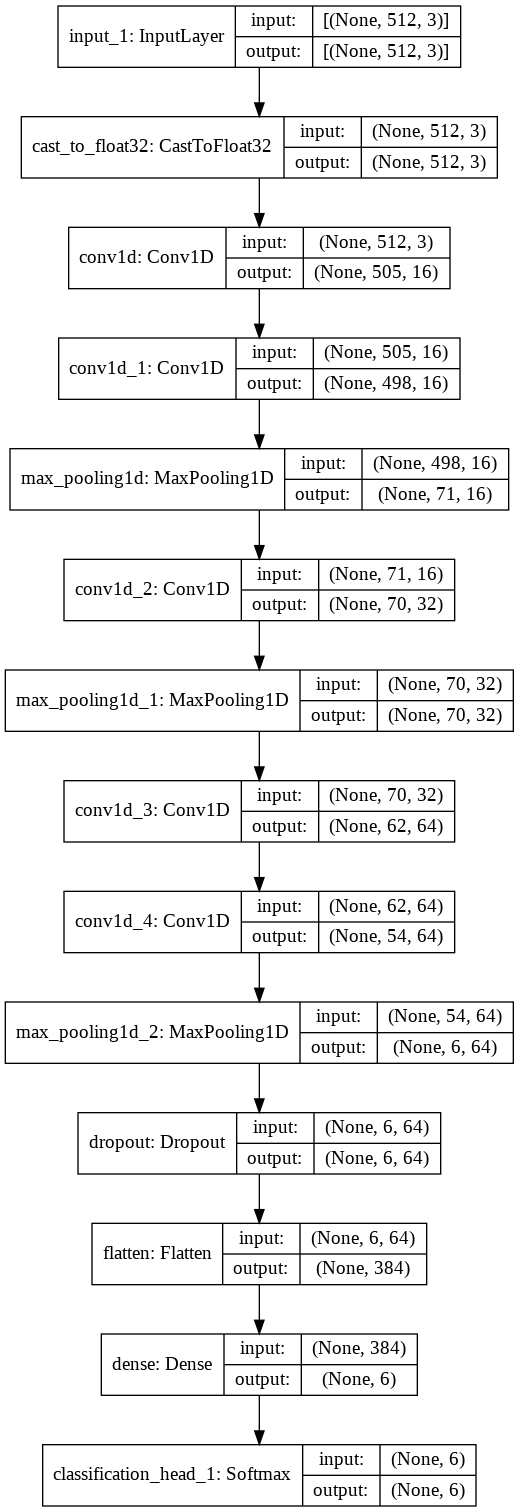

In [20]:
# Export as a Keras Model
model = auto_model.export_model()
print(type(model.summary()))

# print model as image
tf.keras.utils.plot_model(
    model, show_shapes=True, expand_nested=True, to_file="auto_model.png"
)

### Test

In [21]:
utils.test(model)

evaluate test...
write output.csv
